# Calculating Love Numbers using TidalPy's Radial Solver
For more details about TidalPy's radial solver, please see the documentation "TidalPy/Documentation/RadialSolver".

In [1]:
import numpy as np

from TidalPy.RadialSolver import radial_solver, build_rs_input_homogeneous_layers, build_rs_input_from_data
from TidalPy.rheology import Maxwell, Elastic, Andrade, Newton

common_rs_optional_arguments = dict(
    degree_l = 2,
    solve_for = None,
    starting_radius = 0.0,
    start_radius_tolerance = 1.0e-5,
    nondimensionalize = True,
    # Shooting method parameters
    use_kamata = True,
    integration_method = 'DOP853',
    integration_rtol = 1.0e-5,
    integration_atol = 1.0e-8,
    scale_rtols_bylayer_type = False,
    max_num_steps = 500_000,
    expected_size = 1000,
    max_ram_MB = 500,
    max_step = 0,
    # Propagation matrix method parameters
    use_prop_matrix = False,
    core_model = 0,
    # Equation of State solver parameters
    eos_method_bylayer = None,
    surface_pressure = 0.0,
    eos_integration_method = 'DOP853',
    eos_rtol = 1.0e-3,
    eos_atol = 1.0e-5,
    eos_pressure_tol = 1.0e-3,
    eos_max_iters = 40,
    # Error and log reporting
    verbose = False,
    warnings = False,
    raise_on_fail = False,
    perform_checks = True,
    log_info = False
)

## Planet with Homogeneous Layers
Creates radial solver inputs based on user provided parameters for a planet with homogeneous layers (each layer has a constant density, viscosity, shear, etc.).
Checks will be performed to ensure that the inputs are valid.

P_0 = 325.3 GPa.
MOI factor = 0.8407.
k = 0.3473 + -3.264e-10I
h = 0.6955 + -6.248e-10I
l = 0.1179 + -1.554e-10I


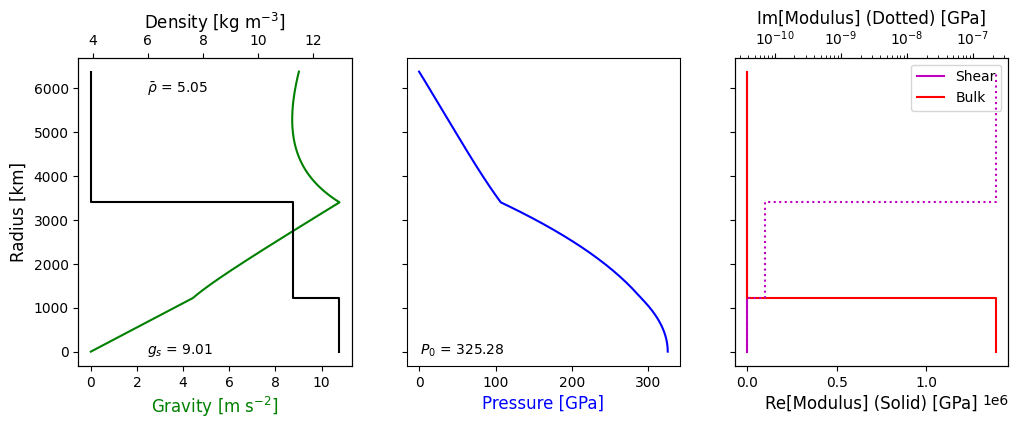

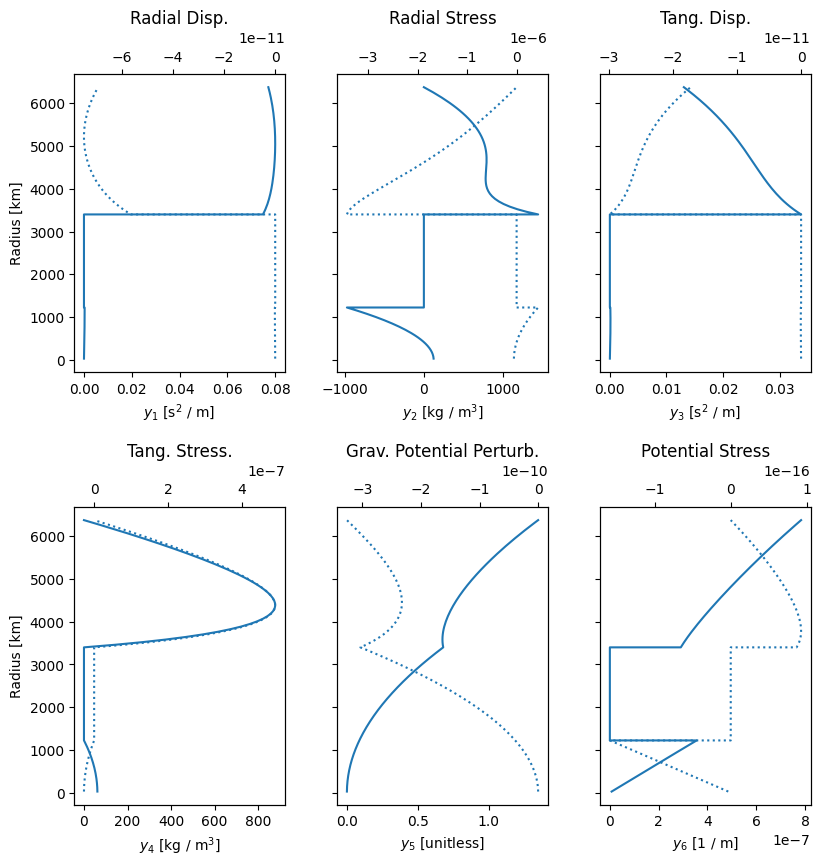

In [2]:
planet_radius              = 6378.1370e3
forcing_frequency          = 2.0 * np.pi / (86400.0 * 1.0)
density_tuple              = (12950, 11255.0, 3934.0)
static_bulk_modulus_tuple  = (1390.5e12, 1014.5e9, 259.7e9)
static_shear_modulus_tuple = (167.8e9, 0.0, 127.5e9)
bulk_viscosity_tuple       = (1.0e30, 1.0e30, 1.0e30)
shear_viscosity_tuple      = (1.0e28, 1.0e3, 1.0e24)
layer_types                = ('solid', 'liquid', 'solid')
layer_is_static_tuple      = (False, True, False)
layer_is_incompressible_tuple = (False, False, False)
radius_fraction_tuple      = (1221500.0/planet_radius, 3400000.0/planet_radius, 1.0)
shear_rheology_tuple       = (Maxwell(), Newton(), Maxwell())
bulk_rheology_tuple        = (Elastic(), Elastic(), Elastic())

# Use TidalPy's helpers to build arrays to be used as inputs to `radial_solver`
rs_inputs = build_rs_input_homogeneous_layers(
    planet_radius,
    forcing_frequency,
    density_tuple,
    static_bulk_modulus_tuple,
    static_shear_modulus_tuple,
    bulk_viscosity_tuple,
    shear_viscosity_tuple,
    layer_types,
    layer_is_static_tuple,
    layer_is_incompressible_tuple,
    shear_rheology_tuple,
    bulk_rheology_tuple,
    radius_fraction_tuple,
    thickness_fraction_tuple = None,
    volume_fraction_tuple = None,
    slices_tuple = None,
    slice_per_layer = 50,
    perform_checks = True)

# Run the solver!
solution = radial_solver(*rs_inputs, **common_rs_optional_arguments)

# Check if it was successful and print the Love numbers
if not solution.success:
    print("Solution was not successful.")
else:
    print(f"P_0 = {solution.central_pressure/1e9:0.1f} GPa.")
    print(f"MOI factor = {solution.moi_factor:0.4f}.")
    print(f"k = {np.real(solution.k):0.4f} + {np.imag(solution.k):0.3e}I")
    print(f"h = {np.real(solution.h):0.4f} + {np.imag(solution.h):0.3e}I")
    print(f"l = {np.real(solution.l):0.4f} + {np.imag(solution.l):0.3e}I")

    # Plot the interior found by TidalPy's Equation of State Solver
    solution.plot_interior()

    # Plot the radial solutions found by RadialSolver
    solution.plot_ys()

In [3]:
# Lets show off some other things that the Radial Solver Solution class can display
solution.print_diagnostics()

# Print all love numbers at once
print("\nAll the world's Love:", solution.love)

# A bunch of other constants
print(f"\nR     = {solution.radius/1000:0.2f}")
print(f"V     = {solution.volume:0.3e}")
print(f"M     = {solution.mass:0.3e}")
print(f"MOI   = {solution.moi:0.3e}")
print(f"MOI_f = {solution.moi_factor:0.4f}")
print(f"rho_b = {solution.density_bulk:0.2f}")
print(f"P0    = {solution.central_pressure/1e9:0.2f}")
print(f"Ps    = {solution.surface_pressure:0.2f}")
print(f"gs    = {solution.surface_gravity:0.2f}")


	Equation of State Solver:
		Success:           True
		Error code:        0
		Message:           Equation of state solver finished without issue.
		Iterations:        2
		Pressure Error:    7.883e-05
		Central Pressure:  3.253e+11
		Mass:              7.883e-05
		MOI (factor):      7.516e+37 (0.841)
		Surface gravity:   9.014e+00

	Radial Solver Results:
		Success:     True
		Error code:  0
		Message:     RadialSolver.ShootingMethod: Completed without any noted issues.
		Steps Taken (per sub-solution):
			Layer 0 = [17 17 13]
			Layer 1 = [4 0 0]
			Layer 2 = [11  7  8]
		k_2 = (0.34734097751143-3.2637187179207443e-10j)
		h_2 = (0.695499091715819-6.248260803355037e-10j)
		l_2 = (0.11790249224285665-1.553832183844901e-10j)

All the world's Love: [[0.34734098-3.26371872e-10j 0.69549909-6.24826080e-10j
  0.11790249-1.55383218e-10j]]

R     = 6378.14
V     = 1.087e+21
M     = 5.494e+24
MOI   = 7.516e+37
MOI_f = 0.8407
rho_b = 5054.89
P0    = 325.28
Ps    = -0.00
gs    = 9.01


## Planet with Inhomogeneous Layers, data loaded from file

If your planet has an interior structure already defined by data arrays (these could be from the literature or from a much more robust equation of state than TidalPy has built in) then it is usually still a good idea to parse these arrays to ensure they are properly formatted to work with `radial_solver`.
That is where the `build_rs_input_from_data` helper function comes in.

Layer 1 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.
Layer 2 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.


P_0 = 357.9 GPa.
MOI factor = 0.8310.
k = 0.2853 + -1.165e-09I
h = 0.5770 + 7.533e-10I
l = 0.0829 + 1.612e-09I


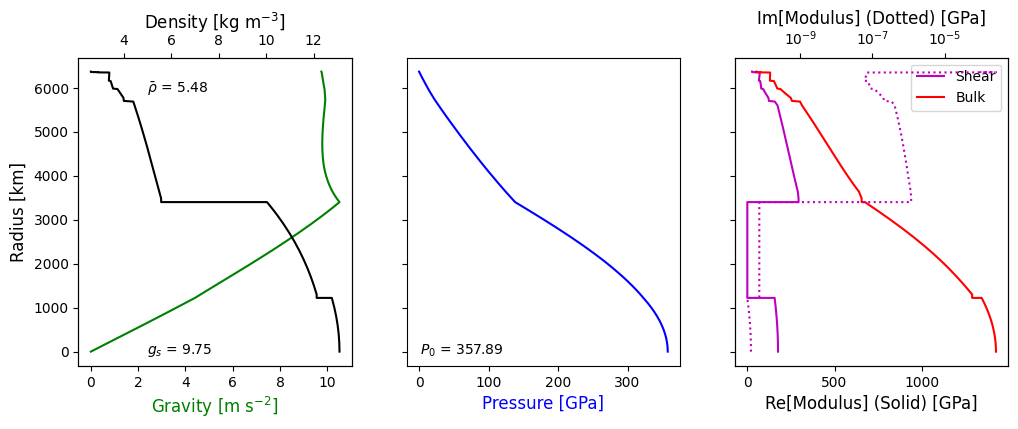

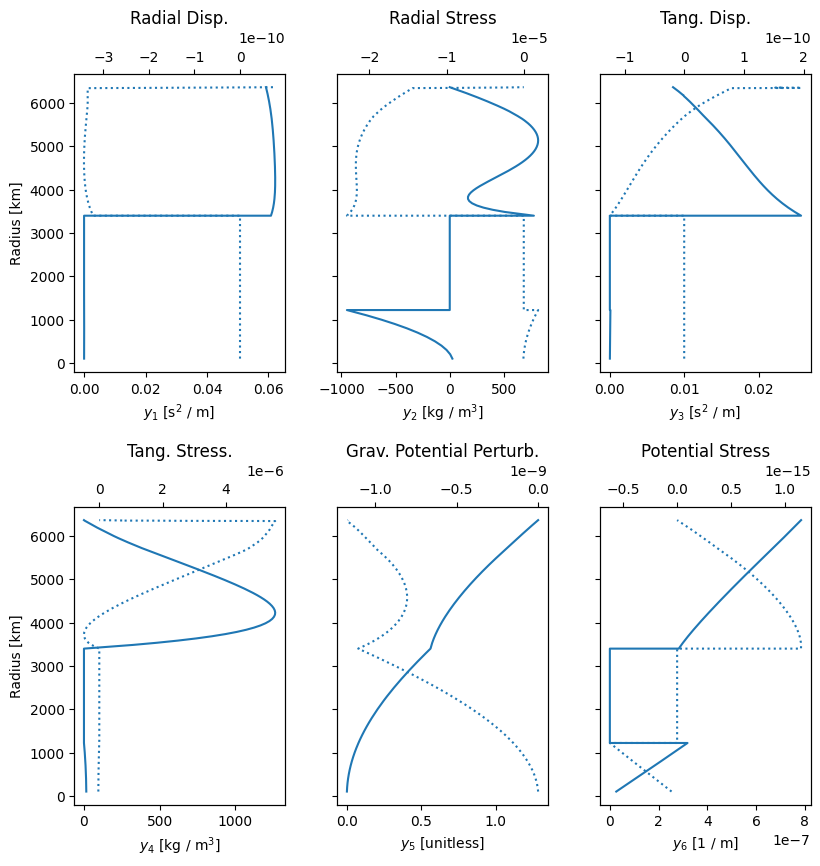

In [4]:
planet_data = np.loadtxt("prem_data.csv", delimiter=',', skiprows=1, dtype=np.float64)
radius_array    = planet_data[:, 0]
density_array   = planet_data[:, 1]
shear_array     = planet_data[:, 4]
bulk_array      = planet_data[:, 5]
viscosity_array = planet_data[:, 6]

# We will assume no bulk dissipation
bulk_viscosity_array = np.zeros(radius_array.size, dtype=np.float64)

planet_radius = radius_array[-1]
forcing_frequency          = 2.0 * np.pi / (86400.0 * 1.0)
layer_types                = ('solid', 'liquid', 'solid')
layer_is_static_tuple      = (False, True, False)
layer_is_incompressible_tuple = (False, False, False)
radius_fraction_tuple      = (1221500.0, 3400000.0, planet_radius)
shear_rheology_tuple       = (Maxwell(), Newton(), Maxwell())
bulk_rheology_tuple        = (Elastic(), Elastic(), Elastic())


# Use TidalPy's helpers to build arrays to be used as inputs to `radial_solver`
rs_inputs = build_rs_input_from_data(
    forcing_frequency,
    radius_array,
    density_array,
    bulk_array,
    shear_array,
    bulk_viscosity_array,
    viscosity_array,
    radius_fraction_tuple,
    layer_types,
    layer_is_static_tuple,
    layer_is_incompressible_tuple,
    shear_rheology_tuple,
    bulk_rheology_tuple,
    perform_checks = True,
    warnings = True)

# Run the solver!
solution = radial_solver(*rs_inputs, **common_rs_optional_arguments)

# Check if it was successful and print the Love numbers
if not solution.success:
    print("Solution was not successful.")
else:
    print(f"P_0 = {solution.central_pressure/1e9:0.1f} GPa.")
    print(f"MOI factor = {solution.moi_factor:0.4f}.")
    print(f"k = {np.real(solution.k):0.4f} + {np.imag(solution.k):0.3e}I")
    print(f"h = {np.real(solution.h):0.4f} + {np.imag(solution.h):0.3e}I")
    print(f"l = {np.real(solution.l):0.4f} + {np.imag(solution.l):0.3e}I")

    # Plot the interior found by TidalPy's Equation of State Solver
    solution.plot_interior()

    # Plot the radial solutions found by RadialSolver
    solution.plot_ys()

## Calculate loading Love numbers

We will calculate both Tidal and Loading Love numbers at the same time (using the same PREM data as the last example).
We do not have to calculate both at the same time but it is more computationally efficient to do so if we know we will want both.

Layer 1 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.
Layer 2 starts at a different radius value than the previous layer's upper radius. Interface radius values must be provided twice, once for each layer above and below the interface. This radius value will be added; other parameters will be set to their values at the slice just after this upper radius value.


P_0 = 357.9 GPa.
MOI factor = 0.8310.
k_tidal   = 0.2853 + -1.165e-09I
h_tidal   = 0.5770 + 7.533e-10I
l_tidal   = 0.0829 + 1.612e-09I
k_loading = -0.2893 + -1.678e-09I
h_loading = -0.9460 + 1.265e-08I
l_loading = 0.0244 + 4.348e-09I


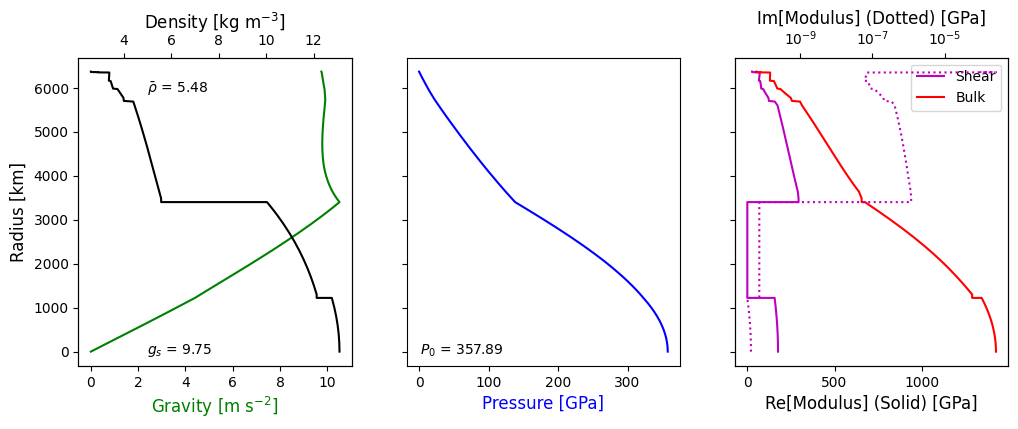

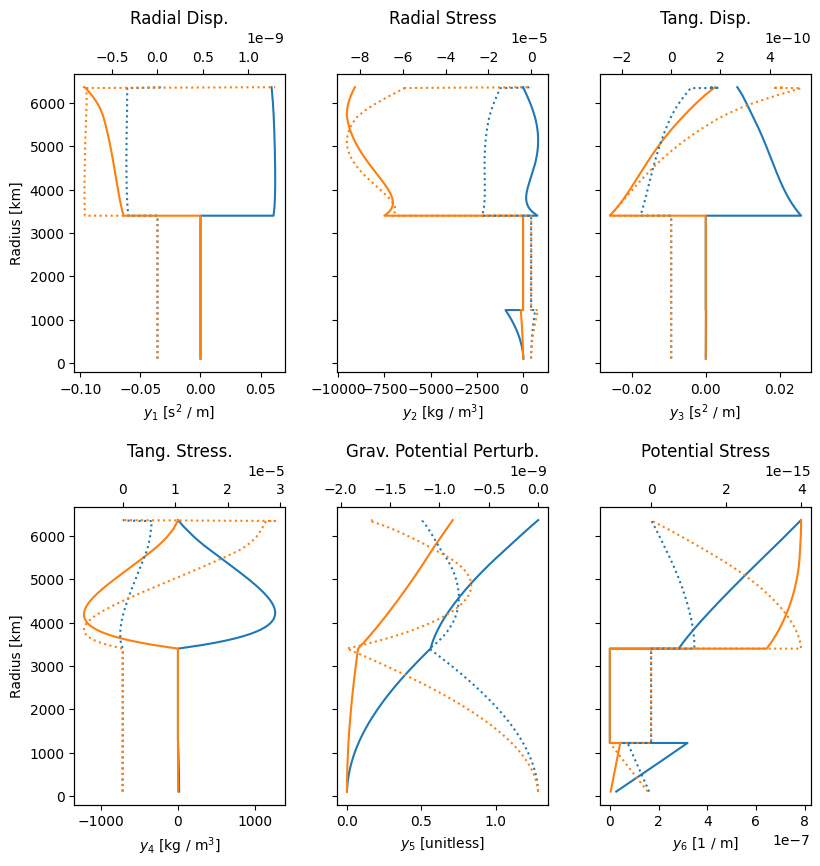

In [5]:
planet_data = np.loadtxt("prem_data.csv", delimiter=',', skiprows=1, dtype=np.float64)
radius_array    = planet_data[:, 0]
density_array   = planet_data[:, 1]
shear_array     = planet_data[:, 4]
bulk_array      = planet_data[:, 5]
viscosity_array = planet_data[:, 6]

# We will assume no bulk dissipation
bulk_viscosity_array = np.zeros(radius_array.size, dtype=np.float64)

planet_radius = radius_array[-1]
forcing_frequency          = 2.0 * np.pi / (86400.0 * 1.0)
layer_types                = ('solid', 'liquid', 'solid')
layer_is_static_tuple      = (False, True, False)
layer_is_incompressible_tuple = (False, False, False)
radius_fraction_tuple      = (1221500.0, 3400000.0, planet_radius)
shear_rheology_tuple       = (Maxwell(), Newton(), Maxwell())
bulk_rheology_tuple        = (Elastic(), Elastic(), Elastic())


# Use TidalPy's helpers to build arrays to be used as inputs to `radial_solver`
rs_inputs = build_rs_input_from_data(
    forcing_frequency,
    radius_array,
    density_array,
    bulk_array,
    shear_array,
    bulk_viscosity_array,
    viscosity_array,
    radius_fraction_tuple,
    layer_types,
    layer_is_static_tuple,
    layer_is_incompressible_tuple,
    shear_rheology_tuple,
    bulk_rheology_tuple,
    perform_checks = True,
    warnings = True)

# Copy all optional arguments from the common dictionary
specific_args = {**common_rs_optional_arguments}
specific_args['solve_for'] = ('tidal', 'loading')  # this could just be ('loading',) but must be a tuple

# Update that we want to calculate loading too. 

# Run the solver!
solution = radial_solver(*rs_inputs, **specific_args)

# Check if it was successful and print the Love numbers
if not solution.success:
    print("Solution was not successful.")
else:
    print(f"P_0 = {solution.central_pressure/1e9:0.1f} GPa.")
    print(f"MOI factor = {solution.moi_factor:0.4f}.")
    print(f"k_tidal   = {np.real(solution.k[0]):0.4f} + {np.imag(solution.k[0]):0.3e}I")
    print(f"h_tidal   = {np.real(solution.h[0]):0.4f} + {np.imag(solution.h[0]):0.3e}I")
    print(f"l_tidal   = {np.real(solution.l[0]):0.4f} + {np.imag(solution.l[0]):0.3e}I")
    print(f"k_loading = {np.real(solution.k[1]):0.4f} + {np.imag(solution.k[1]):0.3e}I")
    print(f"h_loading = {np.real(solution.h[1]):0.4f} + {np.imag(solution.h[1]):0.3e}I")
    print(f"l_loading = {np.real(solution.l[1]):0.4f} + {np.imag(solution.l[1]):0.3e}I")

    # Plot the interior found by TidalPy's Equation of State Solver
    solution.plot_interior()

    # Plot the radial solutions found by RadialSolver
    solution.plot_ys()